In [1]:
import matplotlib as mpl 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas
import matplotlib.pyplot as plt 
import math

In [2]:
# EC2 Constants - price and requests per second

# EC2 Costs (on demand in us-east-1)
t2s = 0.023
t2m = 0.0464
t2l = 0.0928
t2xl = 0.1856
t22xl = 0.3712
elb = 0.0225
elb_lcu = 0.008

# Calculated requests per second in varying EC2 instance types
# With an application load balancer
t2s_rps = 35.0
t2m_rps = 55.0
t2l_rps = 57.0
t2xl_rps = 104.0
t22xl_rps = 177.0

# Without a load balancer
# t2s_rps = 31.0
# t2m_rps = 45.0
# t2l_rps = 53.0
# t2xl_rps = 80.0
# t22xl_rps = 89.0

In [3]:
# Input parameters

# Min/max requests per second
min_rps = 1
max_rps = 275

# Time to process in seconds
process_time = 0.5

# Memory in MB
memory = 128.0

In [9]:
def cost_model(process_time=process_time, memory=memory, min_rps=min_rps, max_rps=max_rps):
    rps = np.linspace(min_rps, max_rps, 100)
    df = pandas.DataFrame({'rps': rps})

    # Lambda cost model
    df['rpm'] = df['rps'] * 60 * 60 * 24 * 30
    df['compute_time'] = df['rpm'] * process_time
    df['gb_per_second'] = df['compute_time'] * memory / 1024.0
    df['gb_per_second'] = df['gb_per_second']  - 400000 # subtract off free
    df['gb_per_second'] = df['gb_per_second'].apply(lambda x: 0 if x < 0 else x)
    df['compute_cost'] = df['gb_per_second'] * 0.00001667
    df['request_millions'] = df['rpm'] - 1000000 # subtract off free
    df['request_millions'] = df['request_millions'] / 1000000
    df['request_cost'] = df['request_millions'] * 0.2
    df['total_cost'] = df['compute_cost'] + df['request_cost']

    # EC2 cost model
    # Assume that requests per second is the highest LCU rule
    df['lcu_total'] = df['rps'] / 25 * elb_lcu

    df['t2s_monthly'] = t2s * 24 * 30 + elb * 24 * 30 + df['lcu_total']
    df['t2m_monthly'] = t2m * 24 * 30 + elb * 24 * 30 + df['lcu_total']
    df['t2l_monthly'] = t2l * 24 * 30 + elb * 24 * 30 + df['lcu_total']
    df['t2xl_monthly'] = t2xl * 24 * 30 + elb * 24 * 30 + df['lcu_total']
    df['t22xl_monthly'] = t22xl * 24 * 30 + elb * 24 * 30 + df['lcu_total']

    # For high availabilty
    min_instances = 3

    df['t2s_required'] = df['rps'].apply(lambda x: max(int(math.ceil(float(x) / t2s_rps)), min_instances))
    df['t2m_required'] = df['rps'].apply(lambda x: max(int(math.ceil(float(x) / t2m_rps)), min_instances))
    df['t2l_required'] = df['rps'].apply(lambda x: max(int(math.ceil(float(x) / t2l_rps)), min_instances))
    df['t2xl_required'] = df['rps'].apply(lambda x: max(int(math.ceil(float(x) / t2xl_rps)), min_instances))
    df['t22xl_required'] = df['rps'].apply(lambda x: max(int(math.ceil(float(x) / t22xl_rps)), min_instances))

    df['t2s_cost'] = df['t2s_required'] * df['t2s_monthly']
    df['t2m_cost'] = df['t2m_required'] * df['t2m_monthly']
    df['t2l_cost'] = df['t2l_required'] * df['t2l_monthly']
    df['t2xl_cost'] = df['t2xl_required'] * df['t2xl_monthly']
    df['t22xl_cost'] = df['t22xl_required'] * df['t22xl_monthly']
    
    return df

def plot(process_time=process_time, memory=memory, min_rps=min_rps, max_rps=max_rps, title='ec2 vs. lambda'):
    df = cost_model(process_time=process_time, memory=memory, min_rps=min_rps, max_rps=max_rps)

    plt.figure()
    plt.title(title)
    plt.ylabel('cost')
    plt.xlabel('rps')
    plt.plot(df['rps'], df['total_cost'], label="lambda")
    plt.plot(df['rps'], df['t2s_cost'], label="t2.small")
    plt.plot(df['rps'], df['t2m_cost'], label="t2.medium")
    plt.plot(df['rps'], df['t2l_cost'], label="t2.large")
    plt.plot(df['rps'], df['t2xl_cost'], label="t2.xlarge")
    plt.plot(df['rps'], df['t22xl_cost'], label="t2.2xlarge")
    plt.legend()
    plt.show()

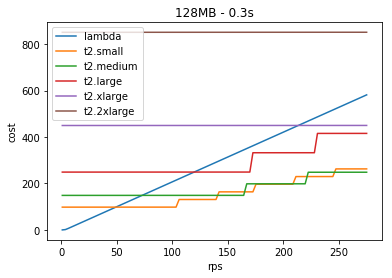

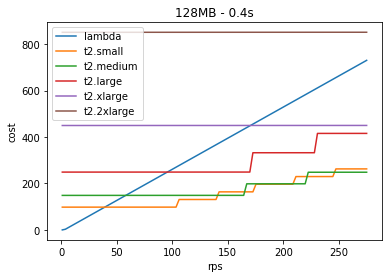

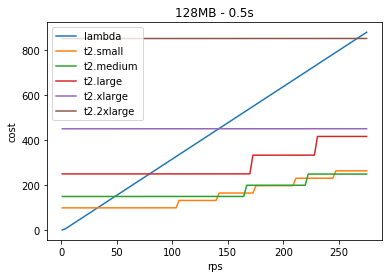

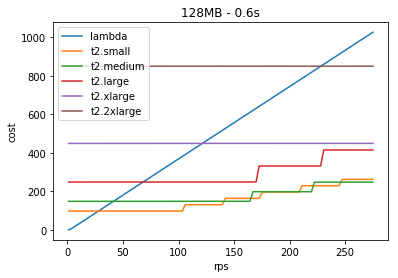

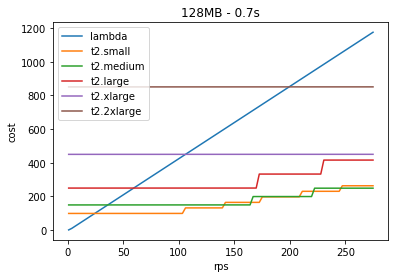

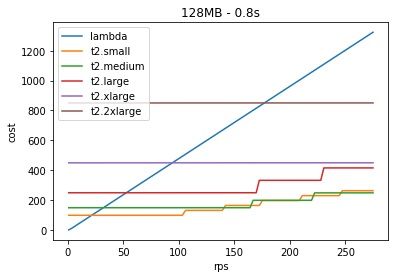

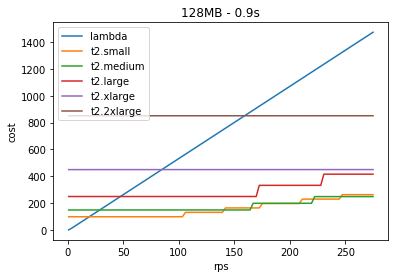

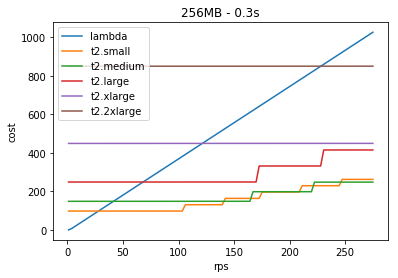

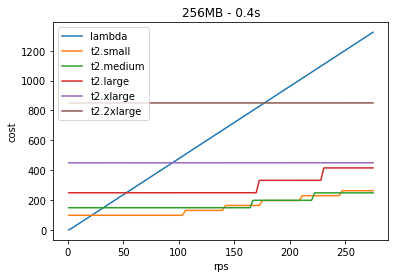

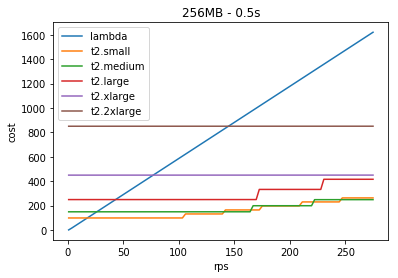

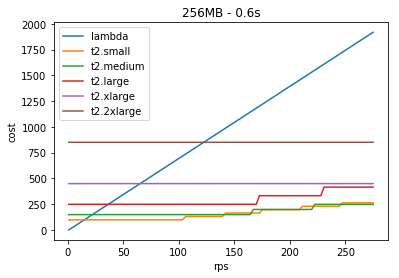

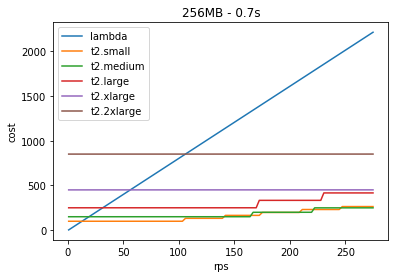

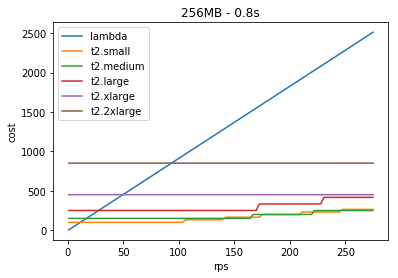

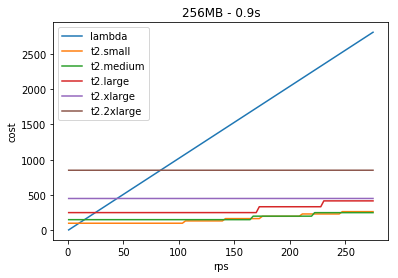

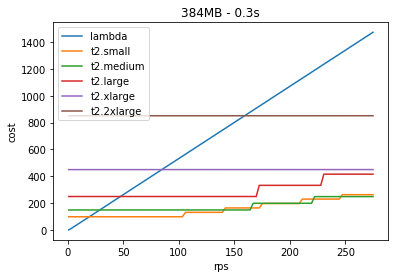

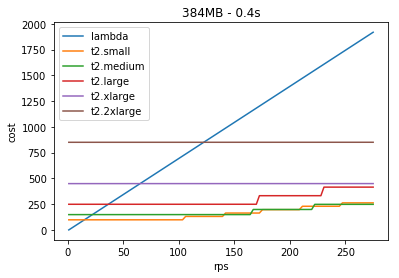

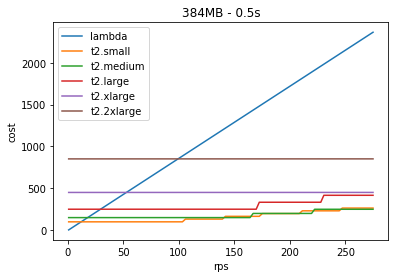

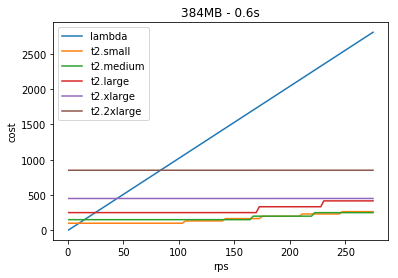

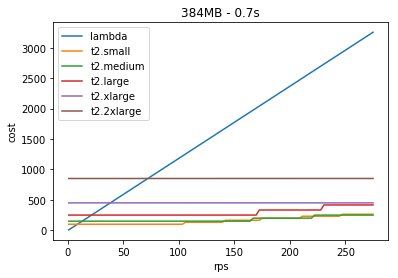

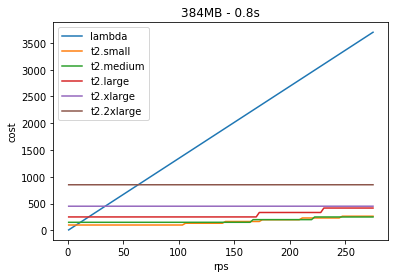

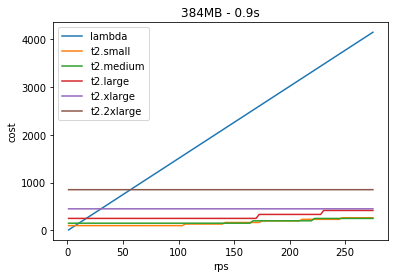

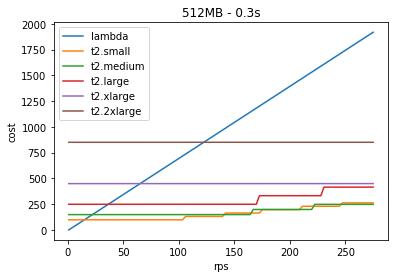

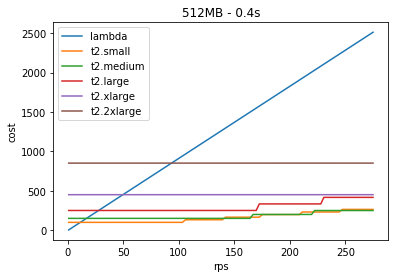

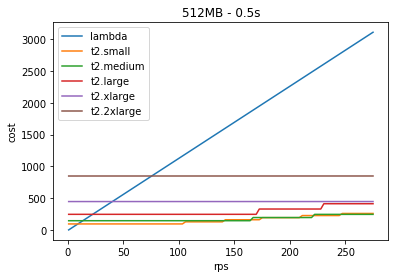

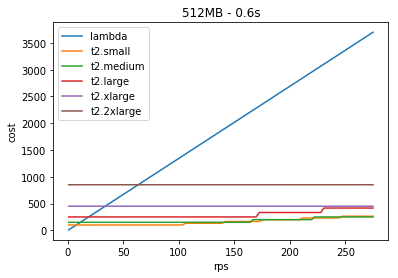

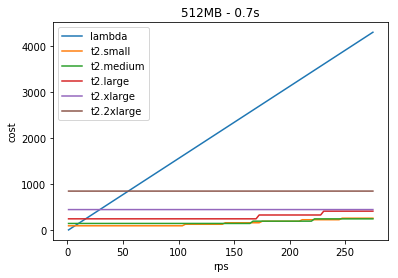

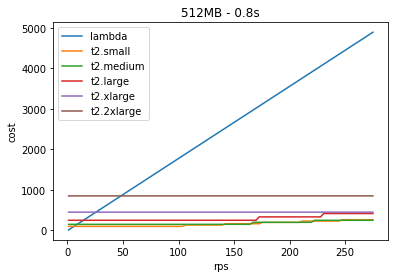

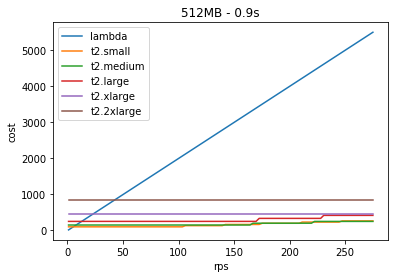

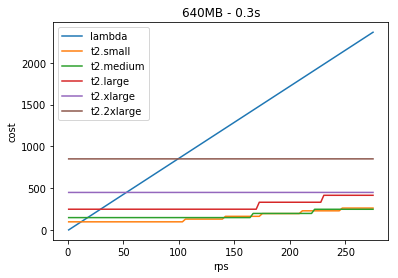

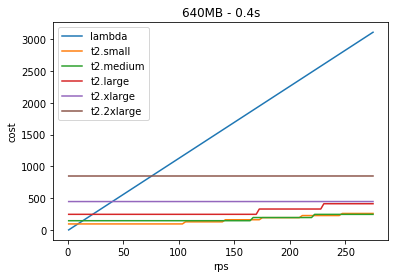

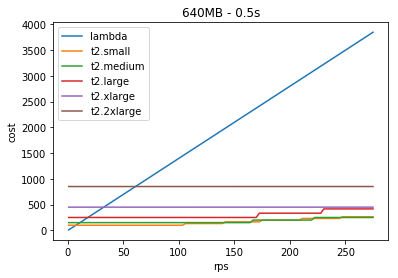

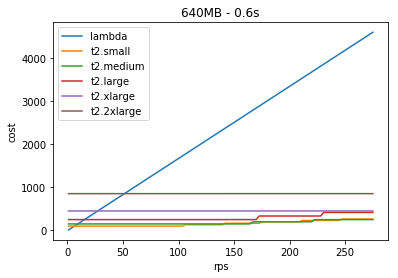

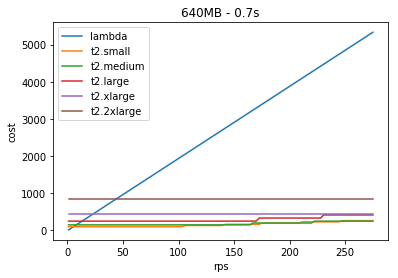

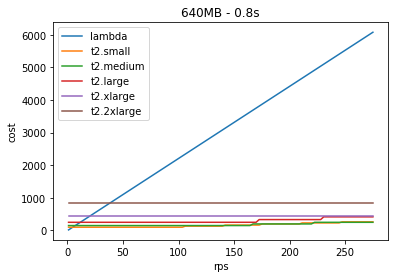

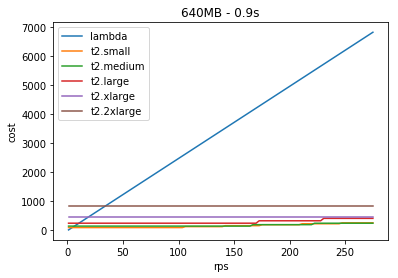

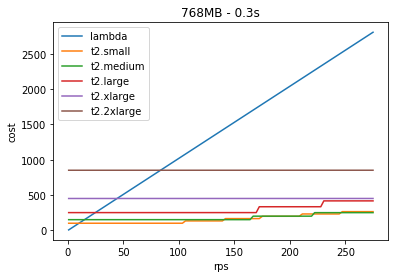

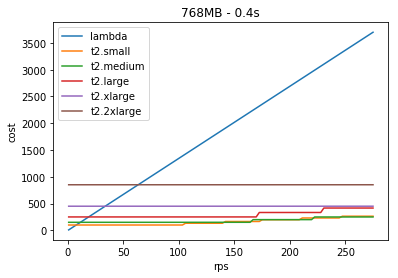

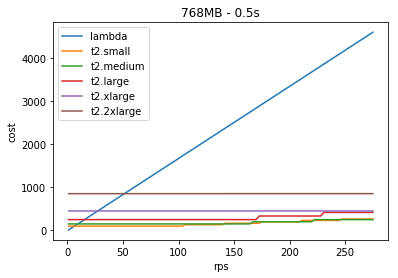

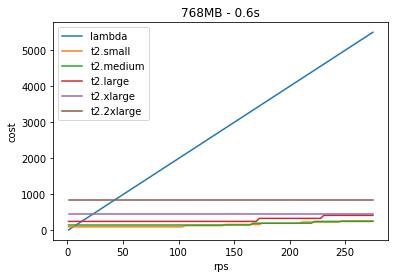

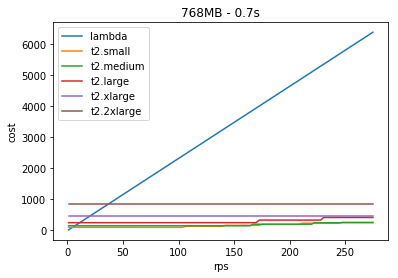

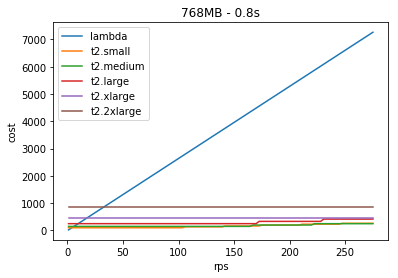

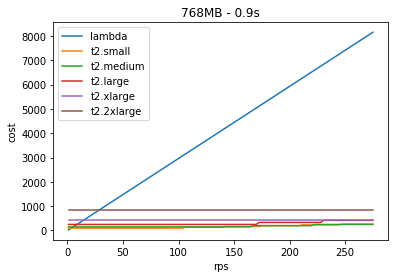

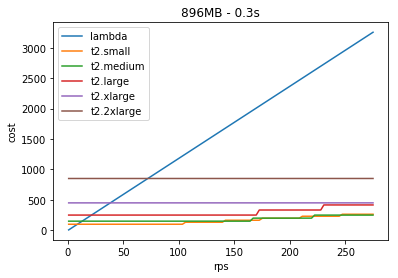

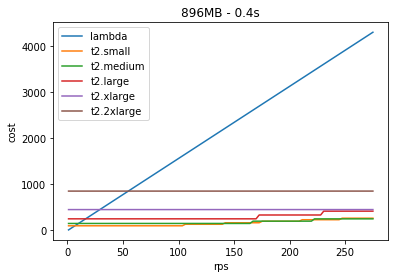

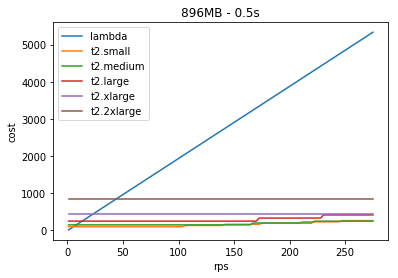

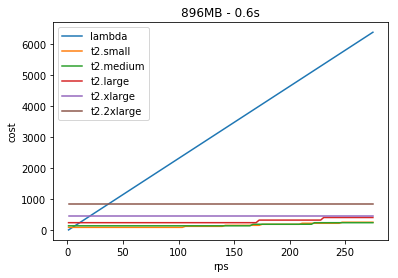

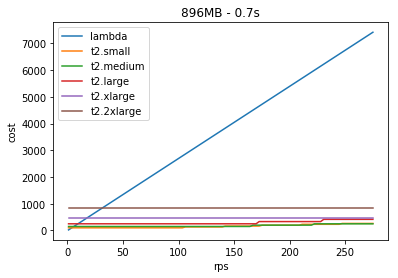

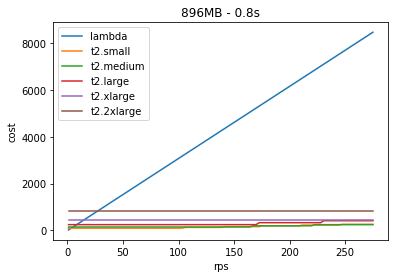

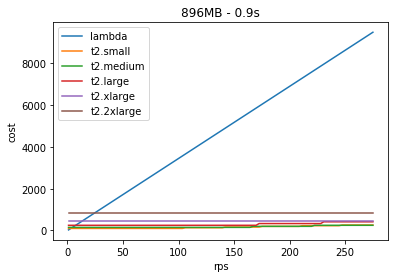

In [28]:

for memory in range(128, 1024, 128):
    for process_time in np.arange(0.3, 1.0, 0.1):
        plot(memory=memory, process_time=process_time, title='{}MB - {:.1f}s'.format(memory, process_time))


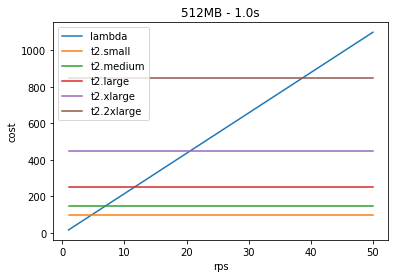

In [33]:

plot(memory=512, process_time=1.0, max_rps=50, title='{}MB - {:.1f}s'.format(512, 1))


In [19]:
# Cost Model for Lambda
rps = 35    # requests per second
mem = .125  # memory consumption in GB
time = 0.5  # execution time in seconds

_rpm = rps * 60 * 60 * 24 * 30                  # convert to requests per month
_compute_time = _rpm * time                     # calculate total compute time
_gb_per_month = _compute_time * mem - 400000    # compute GB/month and subtract off free
_compute_cost = _gb_per_month * 0.00001667      # total compute costs
_request_millions = _rpm - 1000000              # subtract off free
_request_millions = _request_millions / 1000000 # convert to millions of requests
_request_cost = _request_millions * 0.2         # total request cost
_total_cost = _compute_cost + _request_cost     # total cost

print 'RPS: {} -- Memory: {} -- Execution Time: {}'.format(rps, mem, time)
print 'Total monthly cost: ${:,.2f}'.format(_total_cost)

RPS: 35 -- Memory: 0.125 -- Execution Time: 0.5
Total monthly cost: $105.65


In [7]:
# Assume that requests per second is the highest LCU rule
lcu_total = rps / 25 * elb_lcu

t2s_monthly = t2s * 24 * 30 + elb * 24 * 30 + lcu_total
t2m_monthly = t2m * 24 * 30 + elb * 24 * 30 + lcu_total
t2l_monthly = t2l * 24 * 30 + elb * 24 * 30 + lcu_total
t2xl_monthly = t2xl * 24 * 30 + elb * 24 * 30 + lcu_total
t22xl_monthly = t22xl * 24 * 30 + elb * 24 * 30 + lcu_total

t2s_instances = _total_cost / t2s_monthly
t2m_instances = _total_cost / t2m_monthly
t2l_instances = _total_cost / t2l_monthly
t2xl_instances = _total_cost / t2xl_monthly
t22xl_instances = _total_cost / t22xl_monthly

print 'Lambda cost is equivalent to:'
print '{} t2.small instances at ${:,.2f} per instance - total ${:,.2f}'.format(int(math.ceil(t2s_instances)), t2s_monthly, math.ceil(t2s_instances) * t2s_monthly)
print '{} t2.medium instances at ${:,.2f} per instance - total ${:,.2f}'.format(int(math.ceil(t2m_instances)), t2m_monthly, math.ceil(t2m_instances) * t2m_monthly)
print '{} t2.large instances at ${:,.2f} per instance - total ${:,.2f}'.format(int(math.ceil(t2l_instances)), t2l_monthly, math.ceil(t2l_instances) * t2l_monthly)
print '{} t2.xlarge instances at ${:,.2f} per instance - total ${:,.2f}'.format(int(math.ceil(t2xl_instances)), t2xl_monthly, math.ceil(t2xl_instances) * t2xl_monthly)
print '{} t2.2xlarge instances at ${:,.2f} per instance - total ${:,.2f}'.format(int(math.ceil(t22xl_instances)), t22xl_monthly, math.ceil(t22xl_instances) * t22xl_monthly)
print

# For high availabilty
min_instances = 3

t2s_required = max(int(math.ceil(float(rps) / t2s_rps)), min_instances)
t2m_required = max(int(math.ceil(float(rps) / t2m_rps)), min_instances)
t2l_required = max(int(math.ceil(float(rps) / t2l_rps)), min_instances)
t2xl_required = max(int(math.ceil(float(rps) / t2xl_rps)), min_instances)
t22xl_required = max(int(math.ceil(float(rps) / t22xl_rps)), min_instances)

print '{} t2.small instances required - ${:,.2f}'.format(t2s_required, t2s_required * t2s_monthly)
print '{} t2.medium instances required - ${:,.2f}'.format(t2m_required, t2m_required * t2m_monthly)
print '{} t2.large instances required - ${:,.2f}'.format(t2l_required, t2l_required * t2l_monthly)
print '{} t2.xlarge instances required - ${:,.2f}'.format(t2xl_required, t2xl_required * t2xl_monthly)
print '{} t2.2xlarge instances required - ${:,.2f}'.format(t22xl_required, t22xl_required * t22xl_monthly)
print
print 'Total monthly lambda cost: ${:,.2f}'.format(_total_cost)


Lambda cost is equivalent to:
4 t2.small instances at $32.77 per instance - total $131.07
3 t2.medium instances at $49.62 per instance - total $148.85
2 t2.large instances at $83.02 per instance - total $166.05
1 t2.xlarge instances at $149.84 per instance - total $149.84
1 t2.2xlarge instances at $283.47 per instance - total $283.47

3 t2.small instances required - $98.30
3 t2.medium instances required - $148.85
3 t2.large instances required - $249.07
3 t2.xlarge instances required - $449.52
3 t2.2xlarge instances required - $850.42

Total monthly lambda cost: $105.65
